In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size']=20

def determine_parity(df,ip):
    df.insert(ip,'P',-1)
    odd=df.index[df.loc[:]['2S+1']<0].tolist()
    even=df.index[df.loc[:]['2S+1']>0].tolist()
    for i in odd: df.at[i,'P']=1
    for i in even: df.at[i,'P']=0
    return

def termsymbol_to_quantnumber(chterm):
    chsq=chterm[0]
    chlq=chterm[1]
    # multiplicity 2S+1
    sq=int(chsq)
    # angular momenta L
    if chlq=='S': lq=0
    if chlq=='P': lq=1
    if chlq=='D': lq=2
    if chlq=='F': lq=3
    if chlq=='G': lq=4
    if chlq=='H': lq=5
    if chlq=='I': lq=6
    if chlq=='K': lq=7
    # parity
    if (lq%2)==0: pq=0
    if (lq%2)!=0: pq=1
    return sq,lq,pq

def quantnumber_to_termsymbol(sq,lq,pq):
    # multiplicity 2S+1
    chsq=str(sq)
    # angular momenta L
    if lq==0: chlq='S'
    if lq==1: chlq='P'
    if lq==2: chlq='D'
    if lq==3: chlq='F'
    if lq==4: chlq='G'
    if lq==5: chlq='H'
    if lq==6: chlq='I'
    if lq==7: chlq='K'
    # parity
    if pq==0: chpq=''
    if pq!=0: chpq='*'
    chterm=chsq+chlq+chpq
    return chterm

## Input NIST level and configuration data

In [2]:
nist_levs=pd.read_csv("NIST_levels.dat",sep='\s+',skiprows=[0,2],header='infer')
nist_cfgs=pd.read_csv("NIST_cfgs.dat",sep='\s+',skiprows=[0,2],header='infer')
nist_levs.rename(columns={"Level(Ry)":"NIST (Ryd)"},inplace=True)
nist_levs.rename(columns={"Configuration":"Conf"},inplace=True)
nlevnist=len(nist_levs)
# match configuration with AutoStructure labeling and decode spectroscopic terms to quantum numbers
cf=[]
sq=[]
lq=[]
pq=[]
for i in range(nlevnist):
    dumcf=nist_levs.loc[i]['Conf']
    dumterm=nist_levs.loc[i]['Term']
    sqq,lqq,pqq=termsymbol_to_quantnumber(dumterm)
    icfg=nist_cfgs.loc[nist_cfgs.loc[:]['CFG']==dumcf]['i'].tolist()
    sq.append(sqq)
    lq.append(lqq)
    pq.append(pqq)
    cf.append(icfg[0])
# insert new columns into NIST dataframe
nist_levs.insert(2,'2S+1',sq)
nist_levs.insert(3,'L',lq)
nist_levs.insert(4,'P',pq)
nist_levs.insert(5,'CF',cf)

In [3]:
nist_levs.head()

,Conf,Term,2S+1,L,P,CF,J,NIST (Ryd)
0,3s2,1S,1,0,0,1,0,0.000000
1,3s.3p,3P*,3,1,1,2,0,0.199116
2,3s.3p,3P*,3,1,1,2,1,0.199298
3,3s.3p,3P*,3,1,1,2,2,0.199669
4,3s.3p,1P*,1,1,1,2,1,0.319411


## Create NIST terms dataframe from NIST levels

In [4]:
nist_terms=nist_levs.drop_duplicates(subset=['Conf','Term'],keep='first')
nist_terms.reset_index(drop=True,inplace=True)
# compute weighted energy and J quantum number for each term
ntermnist=len(nist_terms)
for i in range(ntermnist):
    dumterm=nist_terms.loc[i][:]
    dumlev=nist_levs.loc[(nist_levs.loc[:]['Conf']==dumterm['Conf'])
                        &(nist_levs.loc[:]['Term']==dumterm['Term'])]
    dumlev.reset_index(drop=True,inplace=True)
    ndumlev=len(dumlev)
    sum_giei=0.
    sum_gi=0
    for j in range(ndumlev):
        gi=2*dumlev.loc[j]['J']+1
        ei=dumlev.loc[j]['NIST (Ryd)']
        sum_gi=sum_gi+gi
        sum_giei=sum_giei+gi*ei
    eiterm=sum_giei/sum_gi
    jiterm=(sum_gi-1)/2
    nist_terms.at[i,'NIST (Ryd)']=eiterm
    nist_terms.at[i,'J']=jiterm

In [5]:
nist_terms.head()

,Conf,Term,2S+1,L,P,CF,J,NIST (Ryd)
0,3s2,1S,1,0,0,1,0,0.000000
1,3s.3p,3P*,3,1,1,2,4,0.199484
2,3s.3p,1P*,1,1,1,2,1,0.319411
3,3s.4s,3S,3,0,0,4,1,0.375418
4,3s.4s,1S,1,0,0,4,0,0.396432


## Input AutoStructure levels and terms

In [12]:
ndum=6
ncfgs=85
nlevs=339
as_levs=pd.read_csv("bare_struct/oic",sep='\s+',skiprows=ncfgs+ndum,header='infer',nrows=nlevs)
determine_parity(as_levs,5)
as_levs.loc[:]['2S+1']=abs(as_levs.loc[:]['2S+1'])
as_levs.rename(columns={"(EK-E1)/RY":"AS (Ryd)"},inplace=True)
nlevs=len(as_levs)

In [13]:
as_levs.head()

,K,LV,T,2S+1,L,P,2J,CF,AS (Ryd)
0,1,298,169,1,0,0,0,1,0.000000
1,2,319,108,3,1,1,0,2,0.178262
2,3,253,108,3,1,1,2,2,0.178382
3,4,188,108,3,1,1,4,2,0.178623
4,5,274,130,1,1,1,2,2,0.327366


In [26]:
nterms=189
tcols=[i for i in range(8)]
as_terms=pd.read_csv("bare_struct/olg",sep='\s+',skiprows=12987,header='infer',nrows=nterms,usecols=tcols)
determine_parity(as_terms,5)
as_terms.loc[:]['2S+1']=abs(as_terms.loc[:]['2S+1'])
as_terms.rename(columns={"(EI-E1)/RY":"AS (Ryd)"},inplace=True)
nterms=len(as_terms)
as_terms.drop(['K*CM','WEIGHTS'],axis=1,inplace=True)

In [15]:
as_terms.head()

,I,T,2S+1,L,P,CF,AS (Ryd)
0,1,169,1,0,0,1,0.000000
1,2,108,3,1,1,2,0.178502
2,3,130,1,1,1,2,0.327366
3,4,151,3,0,0,4,0.352056
4,5,170,1,0,0,4,0.387971


## Include NIST energy levels in AutoStructure dataframe

In [16]:
# include new column to match NIST energy levels
iflag=-1
ncols=len(as_levs.columns)
as_levs.insert(ncols,'NIST (Ryd)',iflag)
as_levs['NIST (Ryd)']=as_levs['NIST (Ryd)'].astype(float)
# match multiplicity, angular momenta, J and configuration between NIST and AutoStructure
for i in range(nlevs):
    dumnist=nist_levs[
           (nist_levs.loc[:]['2S+1']==as_levs.loc[i]['2S+1']) & 
           (nist_levs.loc[:]['L']   ==as_levs.loc[i]['L'])    & 
           (2*nist_levs.loc[:]['J'] ==as_levs.loc[i]['2J'])   & 
           (nist_levs.loc[:]['CF']  ==as_levs.loc[i]['CF'])][:]
    if len(dumnist)==1:
        as_levs.at[i,'NIST (Ryd)']=float(dumnist.iloc[0]['NIST (Ryd)'])

In [17]:
as_levs.head()

,K,LV,T,2S+1,L,P,2J,CF,AS (Ryd),NIST (Ryd)
0,1,298,169,1,0,0,0,1,0.000000,0.000000
1,2,319,108,3,1,1,0,2,0.178262,0.199116
2,3,253,108,3,1,1,2,2,0.178382,0.199298
3,4,188,108,3,1,1,4,2,0.178623,0.199669
4,5,274,130,1,1,1,2,2,0.327366,0.319411


# Creat new column with NIST and AS levels + $\Delta$E

In [18]:
# missing levels (not found in NIST data base)
as_levs.loc[as_levs.loc[:]['NIST (Ryd)']==-1][:].head()

,K,LV,T,2S+1,L,P,2J,CF,AS (Ryd),NIST (Ryd)
126,127,326,115,3,1,1,0,42,0.526580,-1.0
127,128,260,115,3,1,1,2,42,0.526581,-1.0
128,129,195,115,3,1,1,4,42,0.526584,-1.0
151,152,307,178,1,0,0,0,45,0.528470,-1.0
156,157,327,116,3,1,1,0,46,0.528999,-1.0


In [19]:
av_10slv=0.022687450549450507

In [20]:
as_levs['Energy']=as_levs['NIST (Ryd)']
imiss=as_levs.index[as_levs.loc[:]['NIST (Ryd)']==-1][:].tolist()
for i in imiss:
    as_levs.at[i,'Energy']=as_levs.loc[i]['AS (Ryd)']+av_10slv

In [21]:
as_levs.loc[as_levs.loc[:]['NIST (Ryd)']==-1][:].head()

,K,LV,T,2S+1,L,P,2J,CF,AS (Ryd),NIST (Ryd),Energy
126,127,326,115,3,1,1,0,42,0.526580,-1.0,0.549267
127,128,260,115,3,1,1,2,42,0.526581,-1.0,0.549268
128,129,195,115,3,1,1,4,42,0.526584,-1.0,0.549271
151,152,307,178,1,0,0,0,45,0.528470,-1.0,0.551157
156,157,327,116,3,1,1,0,46,0.528999,-1.0,0.551686


## Include NIST energy terms in AutoStructure terms dataframe

In [27]:
# include new column to match NIST energy terms
iflag=-1
ncols=len(as_terms.columns)
as_terms.insert(ncols,'NIST (Ryd)',iflag)
as_terms['NIST (Ryd)']=as_terms['NIST (Ryd)'].astype(float)
# match multiplicity, angular momenta and configuration between NIST and AutoStructure
for i in range(nterms):
    dumnist=nist_terms[
           (nist_terms.loc[:]['2S+1']==as_terms.loc[i]['2S+1']) & 
           (nist_terms.loc[:]['L']   ==as_terms.loc[i]['L'])    & 
           (nist_terms.loc[:]['CF']  ==as_terms.loc[i]['CF'])][:]
    if len(dumnist)==1:
        as_terms.at[i,'NIST (Ryd)']=float(dumnist.iloc[0]['NIST (Ryd)'])

In [28]:
as_terms.head()

,I,T,2S+1,L,P,CF,AS (Ryd),NIST (Ryd)
0,1,169,1,0,0,1,0.000000,0.000000
1,2,108,3,1,1,2,0.178502,0.199484
2,3,130,1,1,1,2,0.327366,0.319411
3,4,151,3,0,0,4,0.352056,0.375418
4,5,170,1,0,0,4,0.387971,0.396432


In [29]:
as_terms.loc[as_terms.loc[:]['NIST (Ryd)']==-1][:].head()

,I,T,2S+1,L,P,CF,AS (Ryd),NIST (Ryd)
70,71,115,3,1,1,42,0.526583,-1.0
83,84,178,1,0,0,45,0.528470,-1.0
86,87,116,3,1,1,46,0.529001,-1.0
91,92,179,1,0,0,49,0.530400,-1.0
94,95,117,3,1,1,50,0.530783,-1.0


In [30]:
as_terms['Energy']=as_terms['NIST (Ryd)']
av_10sterms=0.02264542603174602
imiss=as_terms.index[as_terms.loc[:]['NIST (Ryd)']==-1][:].tolist()
for i in imiss:
    as_terms.at[i,'Energy']=as_terms.loc[i]['AS (Ryd)']+av_10sterms

In [31]:
as_terms.loc[as_terms.loc[:]['NIST (Ryd)']==-1][:].head()

,I,T,2S+1,L,P,CF,AS (Ryd),NIST (Ryd),Energy
70,71,115,3,1,1,42,0.526583,-1.0,0.549228
83,84,178,1,0,0,45,0.528470,-1.0,0.551115
86,87,116,3,1,1,46,0.529001,-1.0,0.551646
91,92,179,1,0,0,49,0.530400,-1.0,0.553045
94,95,117,3,1,1,50,0.530783,-1.0,0.553428


## Create SHFTIC dataframe

In [32]:
shftic=as_levs.copy()

# drop all levels higher than 3s.20d
ncfgmax=79
droplev=shftic.index[shftic.loc[:]['CF']>ncfgmax].tolist()
shftic.drop(droplev,axis=0,inplace=True)

# drop unnecesary columns and flaged rows from SHFTIC dataframe
idrop=['K','T','2S+1','L','P','2J','CF','AS (Ryd)','NIST (Ryd)']
shftic.drop(labels=idrop,axis=1,inplace=True)

shftic.sort_values("LV",axis=0,ascending=True,inplace=True)
# rename header with number of shifts and units
nshiftic=len(shftic)
shftic.rename(columns={"LV": str(nshiftic), "Energy": 1.0},inplace=True)

## Create SHFTLS dataframe

In [33]:
shftls=as_terms.copy()

# drop all levels higher than 3s.20d
dropterm=shftls.index[shftls.loc[:]['CF']>ncfgmax].tolist()
shftls.drop(dropterm,axis=0,inplace=True)

# drop unnecesary columns and flaged rows from SHFTIC dataframe
idrop=['I','2S+1','L','P','CF','AS (Ryd)','NIST (Ryd)']
shftls.drop(labels=idrop,axis=1,inplace=True)

shftls.sort_values("T",axis=0,ascending=True,inplace=True)
# rename header with number of shifts and units
nshiftls=len(shftls)
shftls.rename(columns={"T": str(nshiftls), "Energy": 1.0},inplace=True)

## Print SHFT files

In [34]:
shftic.to_csv('SHFTIC',index=False,sep=' ',header=True,float_format='%.8f')
shftls.to_csv('SHFTLS',index=False,sep=' ',header=True,float_format='%.8f')

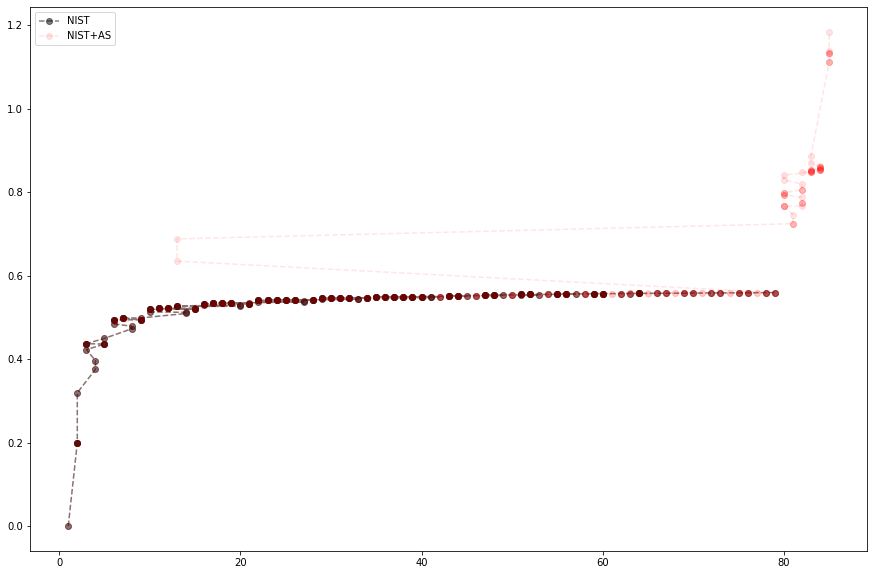

In [35]:
fig=plt.figure(figsize=(15,10))
plt.plot(nist_levs["CF"],nist_levs["NIST (Ryd)"],'ko',linestyle='dashed',alpha=0.5,label='NIST')
plt.plot(as_levs["CF"],as_levs["Energy"],'ro',linestyle='dashed',alpha=0.1,label='NIST+AS')
plt.legend(loc='best')
plt.show()

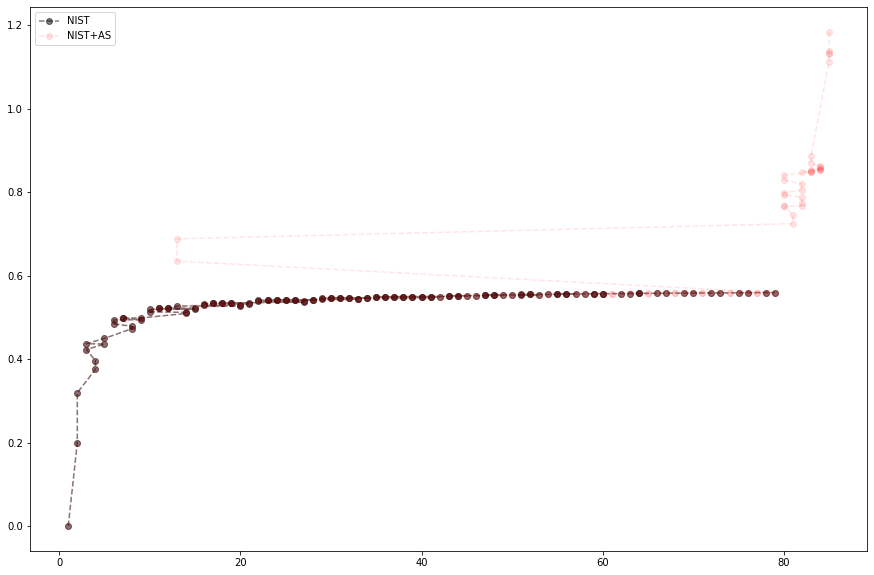

In [36]:
fig=plt.figure(figsize=(15,10))
plt.plot(nist_terms["CF"],nist_terms["NIST (Ryd)"],'ko',linestyle='dashed',alpha=0.5,label='NIST')
plt.plot(as_terms["CF"],as_terms["Energy"],'ro',linestyle='dashed',alpha=0.1,label='NIST+AS')
plt.legend(loc='best')
plt.show()